In [1]:
import random
import glob
import math
from dataclasses import dataclass
from typing import Literal

import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import cbor2

assert torch.cuda.is_available()
random.seed(42)
torch.manual_seed(42)
RUN_KEY = "attention-v5"
summary = SummaryWriter(f"runs/{RUN_KEY}")

In [2]:
BATCH_SIZE = 32

In [3]:
@dataclass
class ModelConfig:
    context_len: int = 512
    n_layers: int = 12
    n_heads: int = 8
    n_embeds: int = 32
    n_tokens: int = 128
    n_added_params: int = 3
    dropout: float = 0.0
    bias: bool = True
    @property
    def n_embed_and_added(self):
        return self.n_embeds + self.n_added_params
    @property
    def n_tokens_and_added(self):
        return self.n_tokens + self.n_added_params

In [4]:
track_paths = glob.glob('moonlight.tokens')
#display(track_paths)
tracks = []
for path in track_paths:
    with open(path, 'rb') as f:
        track_data = cbor2.load(f)
        if len(track_data) < 100:
            print("too short:", path)
        tracks.append([x for x in track_data if x[1] > 0.05])

In [5]:
print(tracks[0][0:5])
print(len(tracks))

[[37, 2.6666666666666665, 0.0, 0.29133858267716534], [49, 3.3333333333333335, 0.0, 0.2283464566929134], [56, 0.3333333333333333, 0.0, 0.36220472440944884], [61, 0.3333333333333333, 0.3333333333333333, 0.23622047244094488], [64, 0.6666666666666666, 0.3333333333333333, 0.33858267716535434]]
1


In [6]:
data = torch.tensor([event for track in tracks for event in track])
split_n = int(0.9 * len(data))
train_data = data[:split_n]
eval_data = data[split_n:]

In [7]:
def get_batch(split: Literal['train', 'eval'], config: ModelConfig, batch_size=BATCH_SIZE):
    data = train_data if split == 'train' else eval_data
    ix = torch.randint(len(data) - config.context_len, (batch_size,))
    x = torch.stack([data[i:i+config.context_len] for i in ix])
    y = torch.stack([data[i+1:i+config.context_len+1] for i in ix])
    return x.cuda(), y.cuda()

In [8]:
get_batch('train', ModelConfig())[0].shape

torch.Size([32, 512, 4])

In [77]:
class SelfAttention(nn.Module):
    def __init__(self, config: ModelConfig, flash=True):
        super().__init__()
        assert config.n_embeds % config.n_heads == 0
        self.config = config
        self.flash = flash
        head_size = config.n_embeds // config.n_heads
        self.key = nn.Linear(config.n_embeds, head_size, bias=config.bias)
        self.query = nn.Linear(config.n_embeds, head_size, bias=config.bias)
        self.value = nn.Linear(config.n_embeds, head_size, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.register_buffer('tril', torch.tril(torch.ones(config.context_len, config.context_len)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        if self.flash:
            dropout = self.config.dropout if self.training else 0.0
            return F.scaled_dot_product_attention(
                q, k, v, attn_mask=None, dropout_p=dropout, is_causal=True)
        w = q @ k.transpose(-2, -1) * C**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        return w @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        head_size = config.n_embeds // config.n_heads
        self.heads = nn.ModuleList([SelfAttention(config) for _ in range(config.n_heads)])
        self.projection = nn.Linear(config.n_heads * head_size, config.n_embeds, bias=False)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.net = nn.Sequential(
            nn.Linear(config.n_embeds, 4 * config.n_embeds),
            nn.ReLU(), # TODO: GELU
            nn.Linear(4 * config.n_embeds, config.n_embeds),
            nn.Dropout(config.dropout),
        )
    def forward(self, x):
        return self.net(x)

class SABlock(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        head_size = config.n_embeds // config.n_heads
        self.sa = MultiHeadAttention(config)
        self.ffwd = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.n_embeds)
        self.ln2 = nn.LayerNorm(config.n_embeds)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [78]:
class Model(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.token_embedding_table = nn.Embedding(config.n_tokens, config.n_embeds)
        self.position_embedding_table = nn.Embedding(config.context_len, config.n_embeds)
        self.drop = nn.Dropout(config.dropout)
        self.blocks = nn.Sequential(*[SABlock(config) for _ in range(config.n_layers)])
        self.layer_norm = nn.LayerNorm(config.n_embed_and_added, bias=config.bias)
        self.lm_head = nn.Linear(config.n_embed_and_added, config.n_tokens_and_added, bias=False)
        # Tie weights
        print(f"{self.token_embedding_table.weight.shape=}")
        print(f"{self.lm_head.weight.shape=}")
        tie_weights = torch.nn.Parameter(self.lm_head.weight[:config.n_tokens, :config.n_embeds])
        print(f"{tie_weights.shape=}")
        self.token_embedding_table.weight = tie_weights
        self.apply(self._init_weights)
        # We scale the weights of residual layers at initialization by a factor of 1/√N
        # where N is the number of residual layers.
        # Language Models are Unsupervised Multitask Learners
        for name, p in self.named_parameters():
            if name.endswith('projection.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layers)) 
                
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, x, targets=None):
        device = x.device
        B, T, C = x.shape
        assert T <= self.config.context_len, T
        tokens = x[:,:,0].long()
        added = x[:,:,1:].view(-1, self.config.context_len, self.config.n_added_params)
        tok_emb = self.token_embedding_table(tokens)
        pos_emb = self.position_embedding_table(torch.arange(T, dtype=torch.long, device=device))
        x = tok_emb + pos_emb
        x = self.drop(x)
        x = self.blocks(x)
        x = torch.cat((x, added), dim=2)
        x = self.layer_norm(x)
        if targets is None:
            # only use last position for generation
            logits = self.lm_head(x[:, [-1], :])
            return logits, None, None, None
        logits = self.lm_head(x)
        B, T, C = logits.shape
        classes = targets[:, :, 0].long()
        added_params = targets[:, :, 1:]
        label_loss = F.cross_entropy(logits.view(B*T, C), classes.view(B*T))
        sq_err = ((added_params[:, :, -self.config.n_added_params:] - logits[:, :, -self.config.n_added_params:]) ** 2)
        added_param_loss = sq_err.mean(dim=1).mean(dim=0).sum()
        loss = label_loss + added_param_loss
        return logits, loss, label_loss, added_param_loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        model.eval()
        out = []
        for _ in range(max_new_tokens):
            idx = idx[:, -self.config.context_len:] # truncate context
            logits, _, _, _ = self(idx)
            # TODO: temperature and top-k
            probs = F.softmax(logits[:, -1, :self.config.n_tokens], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # B, 1
            token = next_token.int().item()
            added_params = logits[:,-1,-self.config.n_added_params:].view(1, self.config.n_added_params)
            next_idx = torch.cat((next_token, added_params), dim=-1) # B, 3
            out.append([token] + added_params.tolist()[0])
            idx = torch.cat((idx, next_idx.view(1, -1, 1 + self.config.n_added_params)), dim=1)
            if next_token.item() == 3:
                break
        return out


In [79]:
class ModelStats:
    def __init__(self, model: Model):
        self.model = model

    def estimate_flops(self):
        pass
        
    def num_parameters(self):
        n_elements = sum(p.numel() for p in self.model.parameters())
        return n_elements

In [80]:
config = ModelConfig()
model = Model(config).cuda()
summary.add_graph(model, get_batch('train', config))
global_training_steps = 0
stats = ModelStats(model)
display(stats.num_parameters())

self.token_embedding_table.weight.shape=torch.Size([128, 32])
self.lm_head.weight.shape=torch.Size([131, 35])
tie_weights.shape=torch.Size([128, 32])


/tmp/ipykernel_292730/2605964146.py:36: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert T <= self.config.context_len, T


177199

In [81]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
autocast_ctx = torch.autocast(device_type='cuda', dtype=dtype)

In [14]:
eval_iters = 100
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train']:#, 'eval']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, config)
            with autocast_ctx:
                logits, loss, _, _ = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [15]:
estimate_loss()

{'train': tensor(7.1638)}

In [31]:
def get_optimizer(named_params, learning_rate=1e-3, betas=(0.9, 0.95), weight_decay=0.1):
    params = {name: param for name, param in named_params if param.requires_grad}
    decay_params = [p for p in params.values() if p.dim() >= 2]
    nodecay_params = [p for p in params.values() if p.dim() < 2]
    groups = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': nodecay_params, 'weight_decay': 0.0}
    ]
    return torch.optim.AdamW(groups, lr=learning_rate, betas=betas, fused=True)

In [82]:
lossi = []
model.train()
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer = get_optimizer(model.named_parameters(), learning_rate=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=split_n, gamma=0.5)
scaler = torch.cuda.amp.GradScaler()
max_steps = 100_000

for i in range(max_steps+1):
    global_training_steps += 1
    Xb, Yb = get_batch('train', config)
    optimizer.zero_grad(set_to_none=True)
    with autocast_ctx:
        logits, loss, label_loss, added_param_loss = model(Xb, Yb)
    if i % 10 == 0:
        summary.add_scalar('loss', loss.item(), global_training_steps)
        summary.add_scalar('label_loss', label_loss.item(), global_training_steps)
        summary.add_scalar('added_param_loss', added_param_loss.item(), global_training_steps)
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # loss.backward()
    # optimizer.step()
    # track
    scheduler.step()
    if i % 100 == 0:
        print(f"{i:7d}/{max_steps}: {loss.item():.4f}, LR={scheduler.get_last_lr()[0]}")
    lossi.append(loss.log10().item())

      0/100000: 6.7633, LR=0.001
    100/100000: 3.8706, LR=0.001
    200/100000: 2.5409, LR=0.001
    300/100000: 1.5496, LR=0.001
    400/100000: 1.0769, LR=0.001
    500/100000: 0.7098, LR=0.0005
    600/100000: 0.4967, LR=0.0005
    700/100000: 0.3627, LR=0.0005
    800/100000: 0.4243, LR=0.0005
    900/100000: 0.2539, LR=0.0005
   1000/100000: 0.2468, LR=0.00025
   1100/100000: 0.1337, LR=0.00025
   1200/100000: 0.1231, LR=0.00025
   1300/100000: 0.1281, LR=0.00025
   1400/100000: 0.0996, LR=0.00025
   1500/100000: 0.1195, LR=0.000125
   1600/100000: 0.0830, LR=0.000125
   1700/100000: 0.0717, LR=0.000125
   1800/100000: 0.0581, LR=0.000125
   1900/100000: 0.0737, LR=0.000125
   2000/100000: 0.0980, LR=6.25e-05
   2100/100000: 0.0461, LR=6.25e-05
   2200/100000: 0.0379, LR=6.25e-05
   2300/100000: 0.0404, LR=6.25e-05
   2400/100000: 0.0377, LR=6.25e-05
   2500/100000: 0.0513, LR=3.125e-05
   2600/100000: 0.0362, LR=3.125e-05
   2700/100000: 0.0352, LR=3.125e-05
   2800/100000: 0.0

KeyboardInterrupt: 

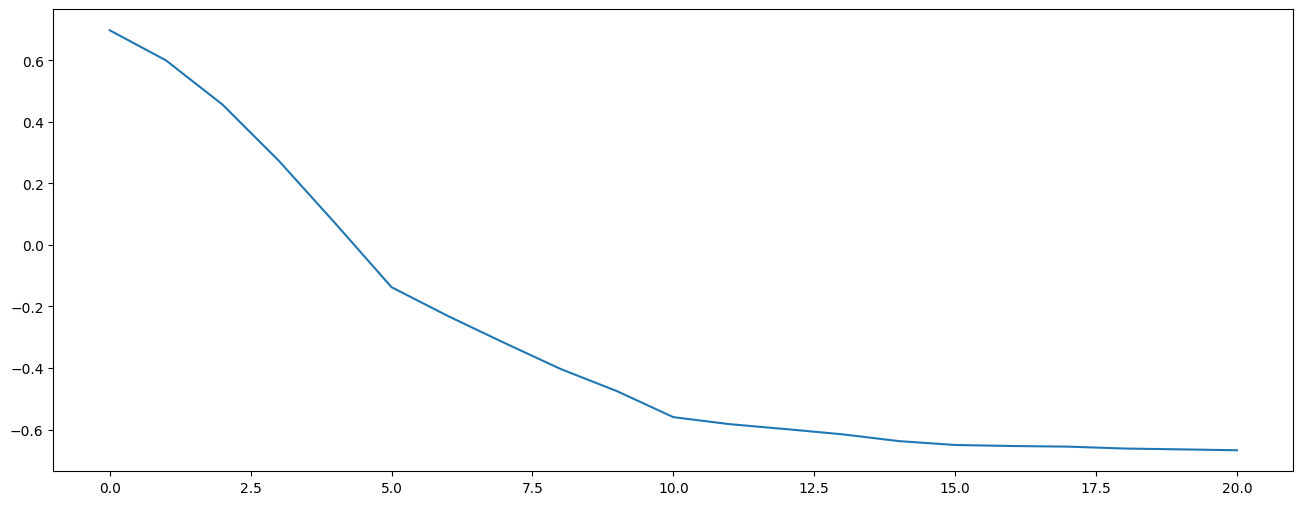

In [17]:
plt.figure(figsize=(16, 6))
# instead, average across 1_000 points
r = (len(lossi) // 100) * 100
plt.plot(torch.tensor(lossi)[:r].view(-1, 100).mean(1))

In [83]:
for sample in range(1):
    gen_ctx = torch.tensor([[[1, 0.0, 0.0, 0.0]] * (config.context_len - 1) + [[2, 0.0, 0.0, 0.0]]], device='cuda')
    generated = model.generate(gen_ctx, max_new_tokens=1_000)
    with open(f"sample-{sample}.tokens", 'wb') as f:
        cbor2.dump(generated, f)
        print("wrote", f.name)

wrote sample-0.tokens


In [84]:
!cargo run -- midify --us-per-beat=1000000 sample-0.tokens > /dev/null 2>&1
!fluidsynth -F sample.wav /usr/share/soundfonts/FluidR3_GM.sf2 sample-0.tokens.mid > /dev/null 2>&1
!ffmpeg -y -i sample.wav -c:a libvorbis -q:a 0 -ac 1 sample.ogg > /dev/null 2>&1
IPython.display.Audio("sample.ogg")

In [34]:
display(generated[:20])

[[32, 3.828429698944092, 0.31007856130599976, 0.06966674327850342],
 [44, 3.5857882499694824, 0.016664773225784302, 0.21387901902198792],
 [48, 1.4406285285949707, 0.20003759860992432, 0.25700172781944275],
 [56, 0.2580792307853699, 0.2822989225387573, 0.2670896649360657],
 [68, 0.24563777446746826, 0.35066401958465576, 0.08773861825466156],
 [63, 0.1754218339920044, 0.4303072988986969, 0.16550213098526],
 [54, 0.35311955213546753, 0.4144783914089203, 0.1762673258781433],
 [54, 0.05162990093231201, 0.5640045404434204, 0.14065000414848328],
 [54, -0.06905114650726318, 0.5904558897018433, 0.12433159351348877],
 [63, -0.09760212898254395, 0.5913704633712769, 0.1209985613822937],
 [54, 0.10802978277206421, 0.4540463984012604, 0.15687058866024017],
 [63, 0.010334491729736328, 0.5585956573486328, 0.14477390050888062],
 [54, 0.10969054698944092, 0.4511720538139343, 0.16273242235183716],
 [63, 0.03731811046600342, 0.543800950050354, 0.15849775075912476],
 [54, 0.1076849102973938, 0.45147386193

In [ ]:
@torch.no_grad()
def split_loss(split):
    model.eval()
    data = {
        "train": train_data,
        "eval": eval_data,
    }[split]
    ix = torch.randint(len(data) - CONTEXT_LEN, (BATCH_SIZE,))
    x = torch.stack([data[i:i+CONTEXT_LEN] for i in ix]).cuda()
    y = torch.stack([data[i+1:i+CONTEXT_LEN+1] for i in ix]).cuda()
    logits, loss = model(x, y)
    print(split, loss.item())
    model.train()

split_loss("train")
split_loss("eval")

In [ ]:
show_midi('sample-0.tokens.mid')

In [84]:
torch.save(model, "")

In [66]:
from music21 import midi
def show_midi(filename):
    stream = midi.translate.midiFilePathToStream(filename)
    stream.show('midi')